# DAMAGE DETECTION USING GPR

## DEPENDENCIES

In [167]:
# import libraries
import math

import numpy as np

import scipy
from scipy.io import loadmat  # for loading matlab files

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import Delaunay

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from sklearn.model_selection import GridSearchCV


## LOAD DATA

In [168]:
# load the results
RX = np.load('RX.npy')
RY = np.load('RY.npy')
RZ = np.load('RZ.npy')

In [169]:
# drop_list
drop_list = np.load('drop_list.npy')  

In [170]:
dim1 = RX.shape[0] # number of different strength drops
dim2 = RX.shape[1] # number of different samples
dim3 = RX.shape[2] # number of monitoring points

In [171]:
BASE_X_A = RX[0,:,0].squeeze()
BASE_X_B = RX[0,:,1].squeeze()
BASE_Y_A = RY[0,:,0].squeeze()
BASE_Y_B = RY[0,:,1].squeeze()
BASE_Z_A = RZ[0,:,0].squeeze()
BASE_Z_B = RZ[0,:,1].squeeze()


In [172]:
DETECT_X_A = RX[1:,:,0].squeeze()
DETECT_X_B = RX[1:,:,1].squeeze()
DETECT_Y_A = RY[1:,:,0].squeeze()
DETECT_Y_B = RY[1:,:,1].squeeze()
DETECT_Z_A = RZ[1:,:,0].squeeze()
DETECT_Z_B = RZ[1:,:,1].squeeze()

DETECT_X_A_AVG = np.mean(DETECT_X_A, axis=1) # model input for prediction
DETECT_X_B_AVG = np.mean(DETECT_X_B, axis=1) # ground truth for output prediction

DETECT_Y_A_AVG = np.mean(DETECT_Y_A, axis=1) # model input for prediction
DETECT_Y_B_AVG = np.mean(DETECT_Y_B, axis=1) # ground truth for output prediction

DETECT_Z_A_AVG = np.mean(DETECT_Z_A, axis=1) # model input for prediction
DETECT_Z_B_AVG = np.mean(DETECT_Z_B, axis=1) # ground truth for output prediction

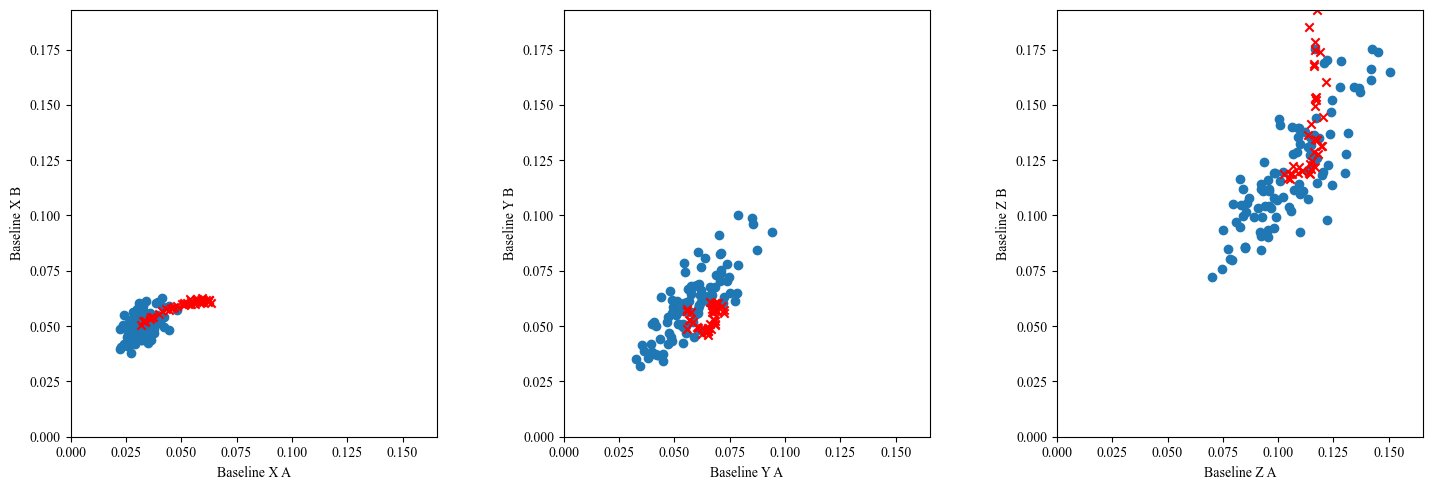

In [173]:
# plot the baseline points for X Y Z three directions, use subplot 1 by 3, unify the limits, 2D plot, A as the horizontal axis, B as the vertical axis

max_disp_A = np.max(np.concatenate((BASE_X_A, BASE_Y_A, BASE_Z_A)))
max_disp_B = np.max(np.concatenate((BASE_X_B, BASE_Y_B, BASE_Z_B)))
limit_A = 1.1*max_disp_A
limit_B = 1.1*max_disp_B


fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Baseline X
ax[0].scatter(BASE_X_A, BASE_X_B)
ax[0].scatter(DETECT_X_A_AVG, DETECT_X_B_AVG, c='r', marker='x')
ax[0].set_xlabel('Baseline X A')
ax[0].set_ylabel('Baseline X B')
ax[0].set_xlim([0, limit_A])
ax[0].set_ylim([0, limit_B])
ax[0].set_aspect('equal', adjustable='box')  # Ensure equal scaling for x and y axes

# Baseline Y
ax[1].scatter(BASE_Y_A, BASE_Y_B)
ax[1].scatter(DETECT_Y_A_AVG, DETECT_Y_B_AVG, c='r', marker='x')
ax[1].set_xlabel('Baseline Y A')
ax[1].set_ylabel('Baseline Y B')
ax[1].set_xlim([0, limit_A])
ax[1].set_ylim([0, limit_B])
ax[1].set_aspect('equal', adjustable='box')  # Ensure equal scaling for x and y axes

# Baseline Z
ax[2].scatter(BASE_Z_A, BASE_Z_B)
ax[2].scatter(DETECT_Z_A_AVG, DETECT_Z_B_AVG, c='r', marker='x')
ax[2].set_xlabel('Baseline Z A')
ax[2].set_ylabel('Baseline Z B')
ax[2].set_xlim([0, limit_A])
ax[2].set_ylim([0, limit_B])
ax[2].set_aspect('equal', adjustable='box')  # Ensure equal scaling for x and y axes

plt.tight_layout()  # Adjust layout to prevent label overlap
plt.show()


In [174]:
# Check the data for prediction

limit_A = 0.3
limit_B = 1

for i in range(DETECT_X_A.shape[0]):
    X_A = DETECT_X_A[i]
    X_B = DETECT_X_B[i]
    
    Y_A = DETECT_Y_A[i]
    Y_B = DETECT_Y_B[i]
    
    Z_A = DETECT_Z_A[i]
    Z_B = DETECT_Z_B[i]
    
    
    
    # fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    # # X
    # ax[0].scatter(X_A, X_B)
    # ax[0].scatter(DETECT_X_A_AVG[i], DETECT_X_B_AVG[i], c='r', marker='x', label='Average')
    # ax[0].set_xlabel('X A')
    # ax[0].set_ylabel('X B')
    # ax[0].set_xlim([0, limit_A])
    # ax[0].set_ylim([0, limit_B])
    
    # # Y
    # ax[1].scatter(Y_A, Y_B)
    # ax[1].scatter(DETECT_Y_A_AVG[i], DETECT_Y_B_AVG[i], c='r', marker='x', label='Average')
    # ax[1].set_xlabel('Y A')
    # ax[1].set_ylabel('Y B')
    # ax[1].set_xlim([0, limit_A])
    # ax[1].set_ylim([0, limit_B])
    
    # # Z
    # ax[2].scatter(Z_A, Z_B)
    # ax[2].scatter(DETECT_Z_A_AVG[i], DETECT_Z_B_AVG[i], c='r', marker='x', label='Average')
    # ax[2].set_xlabel('Z A')
    # ax[2].set_ylabel('Z B')
    # ax[2].set_xlim([0, limit_A])
    # ax[2].set_ylim([0, limit_B])
    
    # plt.tight_layout()  # Adjust layout to prevent label overlap
    # plt.show()

## BASELINE MODEL CONSTRUCTION

In [175]:
# alpha_X = 1 # noise level
# alpha_Y = 1 # noise level
# alpha_Z = 1 # noise level

# alpha_X = 0.3 # noise level
# alpha_Y = 5 # noise level
# alpha_Z = 7.5 # noise level

alpha_X = 1 # noise level
alpha_Y = 0.75 # noise level
alpha_Z = 0.75 # noise levels

In [176]:
# define the kernel
# kernel = ConstantKernel(sigmaM0) * RBF(sigmaF0)
# kernel_X = ConstantKernel(1.0, (1e-2, 1e2)) * RBF(length_scale=0.05, length_scale_bounds=(1e-2, 1e2))
# kernel_Y = ConstantKernel(1.0, (1e-2, 1e2)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
# kernel_Z = ConstantKernel(1.0, (1e-2, 1e2)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

# kernel_X = ConstantKernel(1.0, (1e-2, 1e2)) * RBF(length_scale=1)
# kernel_Y = ConstantKernel(1.0, (1e-2, 1e2)) * RBF(length_scale=1)
# kernel_Z = ConstantKernel(1.0, (1e-2, 1e2)) * RBF(length_scale=1)

kernel_X = ConstantKernel(1.0, (1e-2, 1e2)) * RBF(length_scale=0.1)
kernel_Y = ConstantKernel(1.0, (1e-2, 1e2)) * RBF(length_scale=0.01)
kernel_Z = ConstantKernel(1.0, (1e-2, 1e2)) * RBF(length_scale=0.05)

# define the model using the defined kernel
gprMdl_X = GaussianProcessRegressor(kernel = kernel_X, alpha = alpha_X, normalize_y = True)
gprMdl_Y = GaussianProcessRegressor(kernel = kernel_Y, alpha = alpha_Y, normalize_y = True)
gprMdl_Z = GaussianProcessRegressor(kernel = kernel_Z, alpha = alpha_Z, normalize_y = True)

# Fit the model with the training data
gprMdl_X.fit(BASE_X_A.reshape(-1,1), BASE_X_B.reshape(-1,1))
gprMdl_Y.fit(BASE_Y_A.reshape(-1,1), BASE_Y_B.reshape(-1,1))
gprMdl_Z.fit(BASE_Z_A.reshape(-1,1), BASE_Z_B.reshape(-1,1))


GaussianProcessRegressor(alpha=0.75, kernel=1**2 * RBF(length_scale=0.05),
                         normalize_y=True)

In [177]:
ub_A_X = 1.5*max(BASE_X_A)
ub_A_Y = 1.5*max(BASE_Y_A)
ub_A_Z = 1.5*max(BASE_Z_A)
ub_A = max([ub_A_X, ub_A_Y, ub_A_Z])

# regression
AA_X = np.linspace(0, ub_A_X, 100).reshape(-1,1)
AA_Y = np.linspace(0, ub_A_Y, 100).reshape(-1,1)
AA_Z = np.linspace(0.05, 0.20, 100).reshape(-1,1)

BB_X, BB_X_std = gprMdl_X.predict(AA_X, return_std=True)
BB_Y, BB_Y_std = gprMdl_Y.predict(AA_Y, return_std=True)
BB_Z, BB_Z_std = gprMdl_Z.predict(AA_Z, return_std=True)

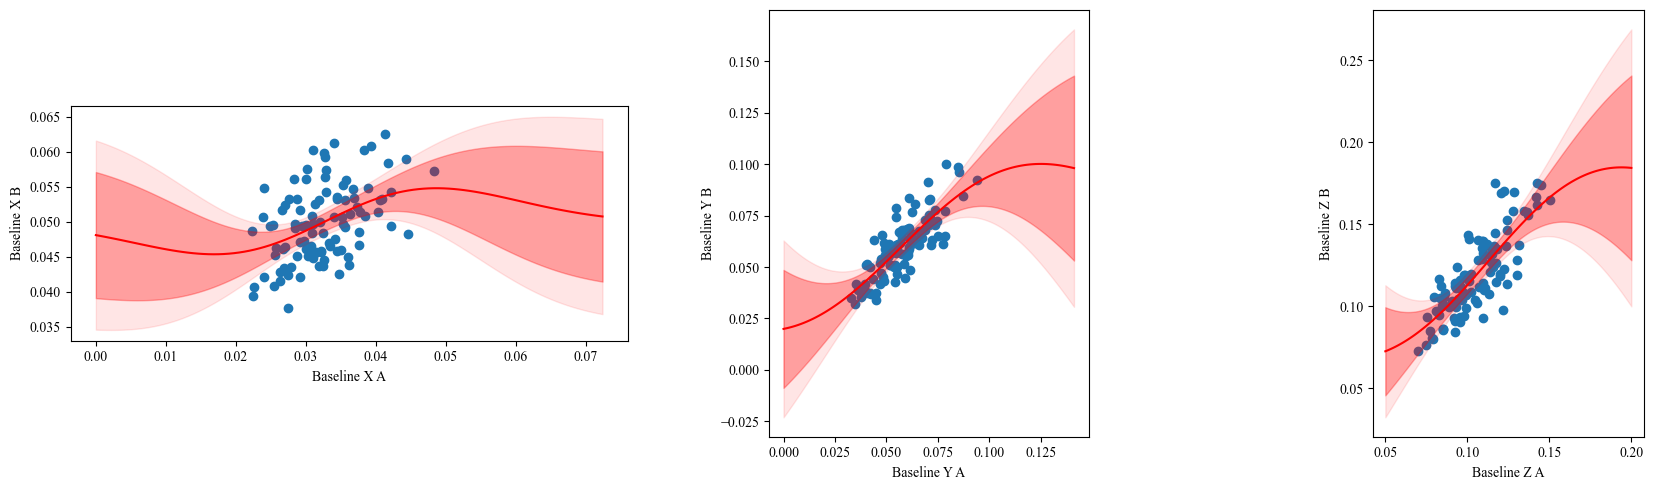

In [178]:
# plot the training data and the regression results
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

X_x_limit = 1.1*max(np.concatenate((BASE_X_A, DETECT_X_A_AVG)))
X_y_limit = 1.1*max(np.concatenate((BASE_X_B, DETECT_X_B_AVG)))

Y_x_limit = 1.1*max(np.concatenate((BASE_Y_A, DETECT_Y_A_AVG)))
Y_y_limit = 1.1*max(np.concatenate((BASE_Y_B, DETECT_Y_B_AVG)))

Z_x_limit = 1.1*max(np.concatenate((BASE_Z_A, DETECT_Z_A_AVG)))
Z_y_limit = 1.1*max(np.concatenate((BASE_Z_B, DETECT_Z_B_AVG)))

# Baseline X
ax[0].scatter(BASE_X_A, BASE_X_B)
ax[0].plot(AA_X, BB_X, c='r', label='Regression')
ax[0].fill_between(AA_X.squeeze(), (BB_X - 2*BB_X_std).squeeze(), (BB_X + 2*BB_X_std).squeeze(), color='r', alpha=0.3)
ax[0].fill_between(AA_X.squeeze(), (BB_X - 3*BB_X_std).squeeze(), (BB_X + 3*BB_X_std).squeeze(), color='r', alpha=0.1)
ax[0].set_xlabel('Baseline X A')
ax[0].set_ylabel('Baseline X B')
# ax[0].set_xlim([0, X_x_limit])
# ax[0].set_ylim([0, X_y_limit])
ax[0].set_aspect('equal', adjustable='box')  # Set equal aspect ratio

# Baseline Y
ax[1].scatter(BASE_Y_A, BASE_Y_B)
ax[1].plot(AA_Y, BB_Y, c='r', label='Regression')
ax[1].fill_between(AA_Y.squeeze(), (BB_Y - 2*BB_Y_std).squeeze(), (BB_Y + 2*BB_Y_std).squeeze(), color='r', alpha=0.3)
ax[1].fill_between(AA_Y.squeeze(), (BB_Y - 3*BB_Y_std).squeeze(), (BB_Y + 3*BB_Y_std).squeeze(), color='r', alpha=0.1)
ax[1].set_xlabel('Baseline Y A')
ax[1].set_ylabel('Baseline Y B')
# ax[1].set_xlim([0, Y_x_limit])
# ax[1].set_ylim([0, Y_y_limit])
ax[1].set_aspect('equal', adjustable='box')  # Set equal aspect ratio

# Baseline Z
ax[2].scatter(BASE_Z_A, BASE_Z_B)
ax[2].plot(AA_Z, BB_Z, c='r', label='Regression')
ax[2].fill_between(AA_Z.squeeze(), (BB_Z - 2*BB_Z_std).squeeze(), (BB_Z + 2*BB_Z_std).squeeze(), color='r', alpha=0.3)
ax[2].fill_between(AA_Z.squeeze(), (BB_Z - 3*BB_Z_std).squeeze(), (BB_Z + 3*BB_Z_std).squeeze(), color='r', alpha=0.1)
ax[2].set_xlabel('Baseline Z A')
ax[2].set_ylabel('Baseline Z B')
# ax[2].set_xlim([0, Z_x_limit])
# ax[2].set_ylim([0, Z_y_limit])
ax[2].set_aspect('equal', adjustable='box')  # Set equal aspect ratio

plt.tight_layout()  # Adjust layout to prevent label overlap
plt.show()





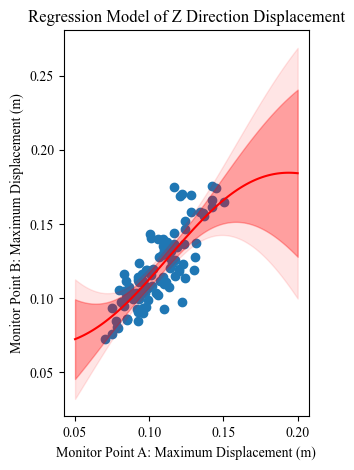

In [179]:
# plot Z direction

# plot the training data and the regression results
fig = plt.figure()
plt.scatter(BASE_Z_A, BASE_Z_B)
plt.plot(AA_Z, BB_Z, c='r', label='Regression')
plt.fill_between(AA_Z.squeeze(), (BB_Z - 2*BB_Z_std).squeeze(), (BB_Z + 2*BB_Z_std).squeeze(), color='r', alpha=0.3)
plt.fill_between(AA_Z.squeeze(), (BB_Z - 3*BB_Z_std).squeeze(), (BB_Z + 3*BB_Z_std).squeeze(), color='r', alpha=0.1)
plt.xlabel('Monitor Point A: Maximum Displacement (m)')
plt.ylabel('Monitor Point B: Maximum Displacement (m)')
# plt.xlim([0, Z_x_limit])
# plt.ylim([0, Z_y_limit])
plt.title('Regression Model of Z Direction Displacement')
plt.gca().set_aspect('equal', adjustable='box')  # Set equal aspect ratio
plt.tight_layout()  # Adjust layout to prevent label overlap

#save the picture
plt.savefig('GPR_Model.png', dpi=300)
plt.show()



## DAMAGE DETECTION & SENSITIVITY ANALYSIS

### PREDICTION

In [180]:
# X
X_B_pred, X_B_pred_std = gprMdl_X.predict(DETECT_X_A_AVG.reshape(-1,1), return_std=True)

In [181]:
# Y
Y_B_pred, Y_B_pred_std = gprMdl_Y.predict(DETECT_Y_A_AVG.reshape(-1,1), return_std=True)

In [182]:
# Z
Z_B_pred, Z_B_pred_std = gprMdl_Z.predict(DETECT_Z_A_AVG.reshape(-1,1), return_std=True)

plot the ground truth and the prediction

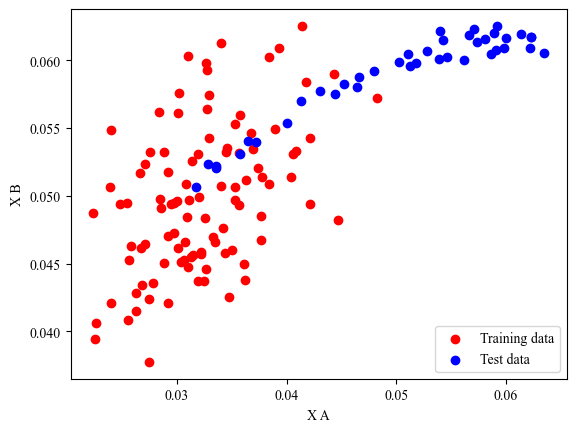

In [183]:
# X
# plot the training dataset, the prediction and the ground truth

fig = plt.figure()
plt.scatter(BASE_X_A, BASE_X_B, c='r', label='Training data')
# plt.scatter(BASE_X_A, BASE_X_B_PRED, c='g', label='Regression')
plt.scatter(DETECT_X_A_AVG, DETECT_X_B_AVG, c='b', label='Test data')
# plt.plot(DETECT_X_A_AVG, X_B_pred, c='g', label='Prediction')
plt.xlabel('X A')
plt.ylabel('X B')
plt.legend()
plt.show()

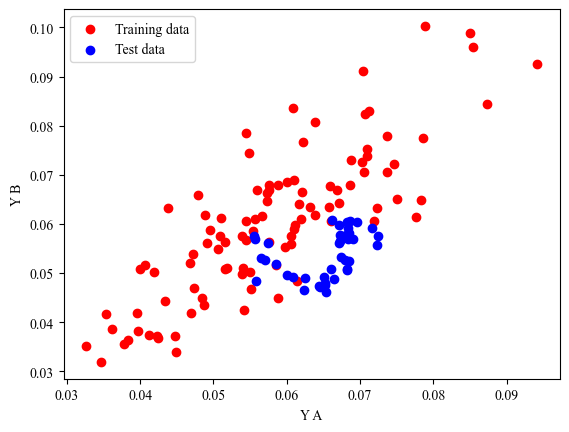

In [184]:
# Y
# plot the training dataset, the prediction and the ground truth

fig = plt.figure()
plt.scatter(BASE_Y_A, BASE_Y_B, c='r', label='Training data')
# plt.scatter(BASE_Y_A, BASE_Y_B_PRED, c='g', label='Regression')
plt.scatter(DETECT_Y_A_AVG, DETECT_Y_B_AVG, c='b', label='Test data')
# plt.plot(DETECT_Y_A_AVG, Y_B_pred, c='g', label='Prediction')
plt.xlabel('Y A')
plt.ylabel('Y B')
plt.legend()
plt.show()




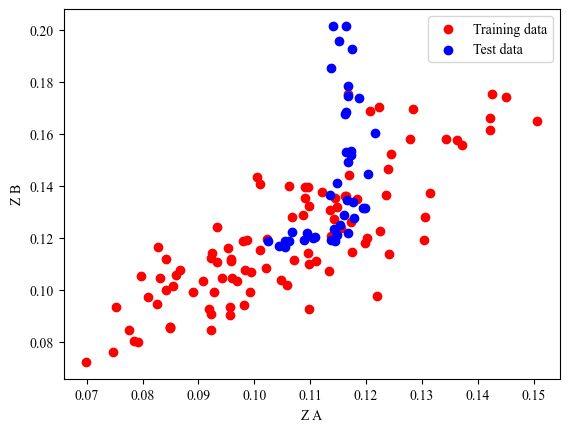

In [185]:
# Z
# plot the training dataset, the prediction and the ground truth

fig = plt.figure()
plt.scatter(BASE_Z_A, BASE_Z_B, c='r', label='Training data')
# plt.scatter(BASE_Z_A, BASE_Z_B_PRED, c='g', label='Regression')
plt.scatter(DETECT_Z_A_AVG, DETECT_Z_B_AVG, c='b', label='Test data')
# plt.plot(DETECT_Z_A_AVG, Z_B_pred, c='g', label='Prediction')
plt.xlabel('Z A')
plt.ylabel('Z B')
plt.legend()
plt.show()


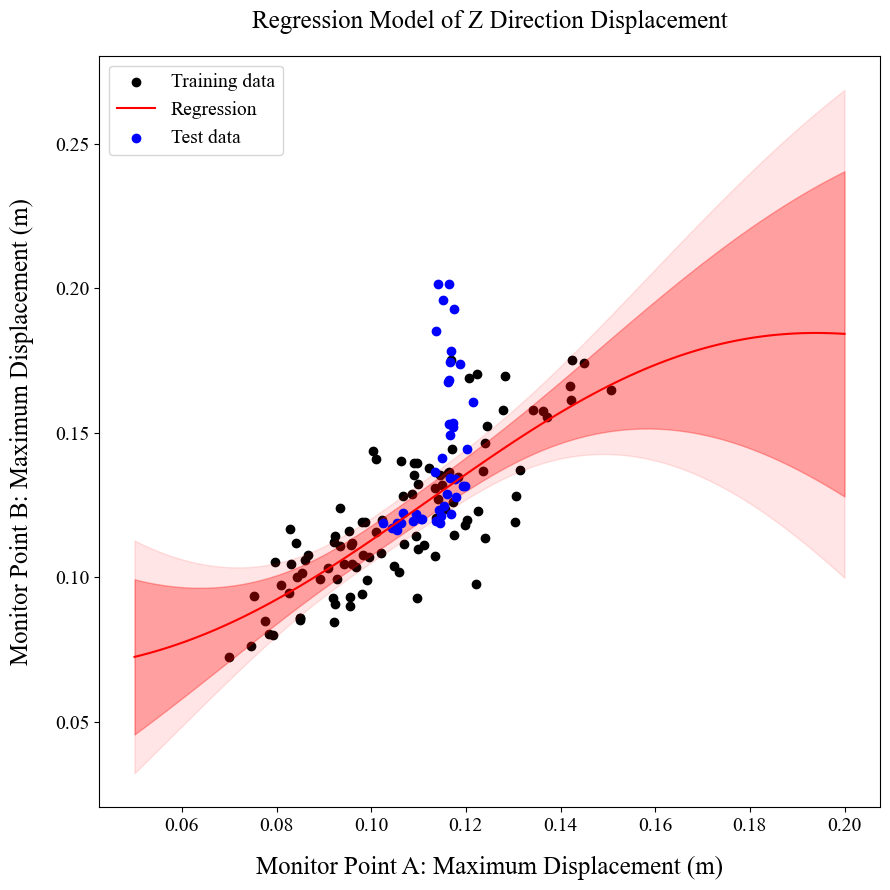

In [186]:
# plot the training data and the regression results
fig = plt.figure(figsize=(9, 9))
plt.scatter(BASE_Z_A, BASE_Z_B, c='k', label='Training data')
plt.plot(AA_Z, BB_Z, c='r', label='Regression')
plt.fill_between(AA_Z.squeeze(), (BB_Z - 2*BB_Z_std).squeeze(), (BB_Z + 2*BB_Z_std).squeeze(), color='r', alpha=0.3)
plt.fill_between(AA_Z.squeeze(), (BB_Z - 3*BB_Z_std).squeeze(), (BB_Z + 3*BB_Z_std).squeeze(), color='r', alpha=0.1)
plt.scatter(DETECT_Z_A_AVG, DETECT_Z_B_AVG, c='b', label='Test data')

# Enlarged font sizes with padding
plt.xlabel('Monitor Point A: Maximum Displacement (m)', fontsize=18, labelpad=15)
plt.ylabel('Monitor Point B: Maximum Displacement (m)', fontsize=18, labelpad=15)
plt.title('Regression Model of Z Direction Displacement', fontsize=18, pad=20)
plt.legend(fontsize=14)

# Adjust tick label font size
plt.tick_params(axis='both', which='major', labelsize=14)

# Optional axis limits
# plt.xlim([0, 0.25])
# plt.ylim([0, 0.25])

# Aspect ratio and layout adjustments
# plt.gca().set_aspect('equal', adjustable='box')  # Set equal aspect ratio
plt.tight_layout()  # Adjust layout to prevent label overlap

plt.show()


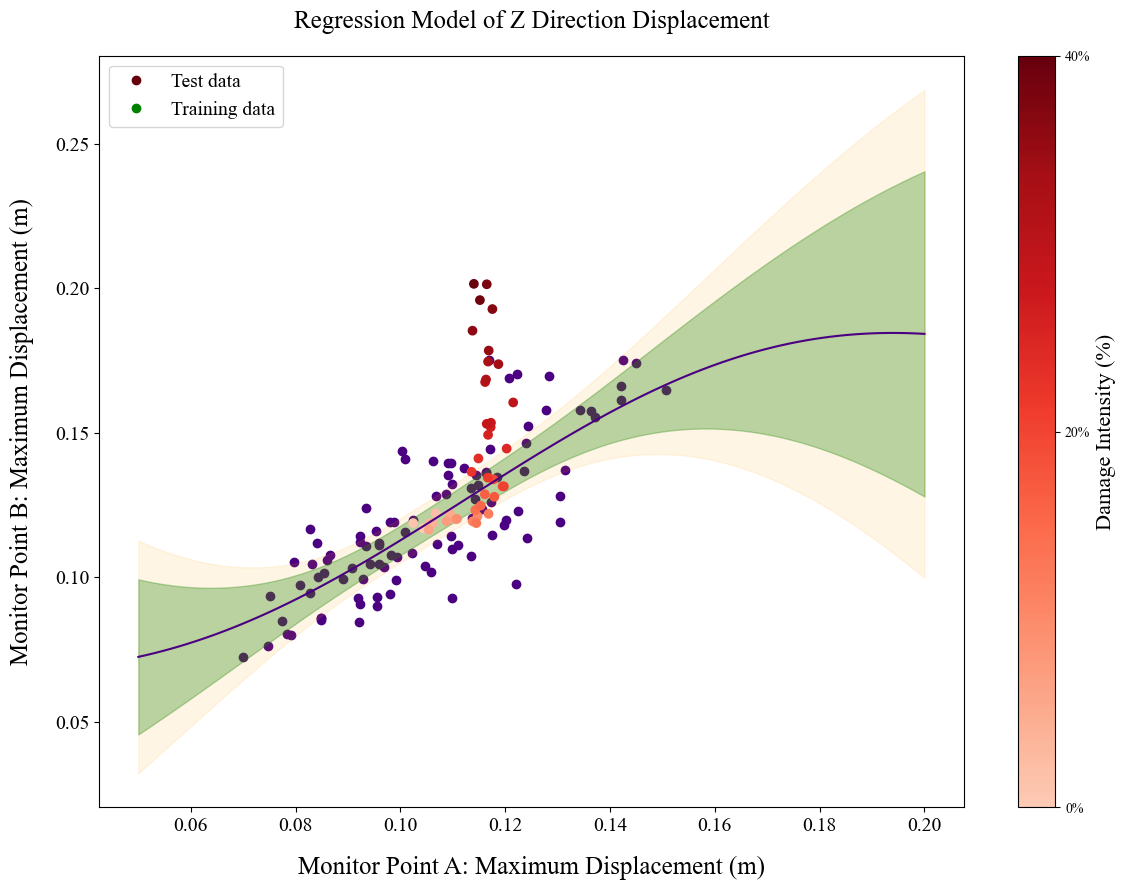

In [187]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap

# Define a custom red colormap that starts from a light red and goes to deep red
light_to_dark_red = LinearSegmentedColormap.from_list("light_to_dark_red", cm.Reds(np.linspace(0.2, 1, 256)))

# Plot the training data and the regression results
fig, ax = plt.subplots(figsize=(12, 9))
ax.scatter(BASE_Z_A, BASE_Z_B, c='indigo', label='Training data')
ax.plot(AA_Z, BB_Z, c='indigo', label='Regression')
ax.fill_between(AA_Z.squeeze(), (BB_Z - 2*BB_Z_std).squeeze(), (BB_Z + 2*BB_Z_std).squeeze(), color='g', alpha=0.3)
ax.fill_between(AA_Z.squeeze(), (BB_Z - 3*BB_Z_std).squeeze(), (BB_Z + 3*BB_Z_std).squeeze(), color='orange', alpha=0.1)

# Generate colors from light to dark based on damage intensity
damage_levels = np.linspace(0, 1, len(DETECT_Z_A_AVG))  # Normalized values from 0 to 1

# Plot test data with the custom red gradient
scatter = ax.scatter(DETECT_Z_A_AVG, DETECT_Z_B_AVG, c=damage_levels, cmap=light_to_dark_red, label='Test data')

# Add colorbar to indicate damage levels from 0% to 40%
cbar = plt.colorbar(scatter, ax=ax, orientation='vertical')
cbar.set_label('Damage Intensity (%)', fontsize=16)
cbar.set_ticks([0, 0.5, 1])  # Set ticks to show 0%, 20%, and 40%
cbar.set_ticklabels(['0%', '20%', '40%'])

# Enlarged font sizes with padding
ax.set_xlabel('Monitor Point A: Maximum Displacement (m)', fontsize=18, labelpad=15)
ax.set_ylabel('Monitor Point B: Maximum Displacement (m)', fontsize=18, labelpad=15)
ax.set_title('Regression Model of Z Direction Displacement', fontsize=18, pad=20)

# Use the deepest red for the Test Data legend label
ax.legend(handles=[plt.Line2D([], [], marker='o', color=light_to_dark_red(1.0), linestyle='None', label='Test data'),
                   plt.Line2D([], [], marker='o', color='g', linestyle='None', label='Training data')],
          fontsize=14)

# Adjust tick label font size
plt.tick_params(axis='both', which='major', labelsize=14)

# Optional axis limits
# ax.set_xlim([0, 0.25])
# ax.set_ylim([0, 0.25])

# Aspect ratio and layout adjustments
plt.tight_layout()  # Adjust layout to prevent label overlap

plt.show()


In [188]:
import numpy as np
import plotly.graph_objects as go

# Create the figure
fig = go.Figure()

# Plot training data as scatter points
fig.add_trace(go.Scatter(
    x=BASE_Z_A, y=BASE_Z_B,
    mode='markers',
    marker=dict(color='green'),
    name='Training data'
))

# Plot regression line with a more visible style
fig.add_trace(go.Scatter(
    x=AA_Z, y=BB_Z,
    mode='lines',
    line=dict(color='darkblue', width=4),  # Set to dark blue with increased width for high visibility
    name='Regression'
))

# Add confidence interval bands
fig.add_trace(go.Scatter(
    x=np.concatenate([AA_Z.squeeze(), AA_Z[::-1].squeeze()]),
    y=np.concatenate([(BB_Z - 2 * BB_Z_std).squeeze(), (BB_Z + 2 * BB_Z_std)[::-1].squeeze()]),
    fill='toself',
    fillcolor='rgba(0, 128, 0, 0.3)',
    line=dict(color='rgba(255,255,255,0)'),
    showlegend=False
))
fig.add_trace(go.Scatter(
    x=np.concatenate([AA_Z.squeeze(), AA_Z[::-1].squeeze()]),
    y=np.concatenate([(BB_Z - 3 * BB_Z_std).squeeze(), (BB_Z + 3 * BB_Z_std)[::-1].squeeze()]),
    fill='toself',
    fillcolor='rgba(0, 128, 0, 0.1)',
    line=dict(color='rgba(255,255,255,0)'),
    showlegend=False
))

# Plot test data with custom red gradient for damage intensity
damage_levels = np.linspace(0, 1, len(DETECT_Z_A_AVG))  # Normalized values for color mapping
fig.add_trace(go.Scatter(
    x=DETECT_Z_A_AVG, y=DETECT_Z_B_AVG,
    mode='markers',
    marker=dict(
        color=damage_levels,
        colorscale=[  # Custom colorscale from light red to deep red
            [0, 'rgba(255, 160, 160, 1)'],  # Light red
            [1, 'rgba(139, 0, 0, 1)']       # Deep red
        ],
        colorbar=dict(
            title='Damage',  # Changed title to "Damage"
            tickvals=[0, 0.5, 1],
            ticktext=['0%', '20%', '40%'],
            x=1.1  # Position colorbar to the right of the plot
        ),
    ),
    name='Test data'
))

# Set axis labels, title, and layout properties with black font color
fig.update_layout(
    title=dict(
        text='Regression Model of Z Direction Displacement',
        x=0.5,  # Center the title
        font=dict(size=18, family='Times New Roman', color='black')
    ),
    xaxis_title='Monitor Point A: Maximum Displacement (m)',
    yaxis_title='Monitor Point B: Maximum Displacement (m)',
    font=dict(family='Times New Roman', size=14, color='black'),
    xaxis=dict(
        title_font=dict(size=18, color='black'), 
        showgrid=False,
        showline=True,  # Show axis line
        linecolor='black',
        ticks='outside',  # Draw ticks outside
        tickwidth=1,
        tickcolor='black'
    ),
    yaxis=dict(
        title_font=dict(size=18, color='black'), 
        showgrid=False,
        showline=True,  # Show axis line
        linecolor='black',
        ticks='outside',  # Draw ticks outside
        tickwidth=1,
        tickcolor='black'
    ),
    legend=dict(font=dict(size=14, color='black'), x=0.02, y=0.98),  # Move legend to top left corner
    plot_bgcolor='white',  # Set plot background to white
)

# Add a thin black border around the plot area using a rectangle shape
fig.update_layout(
    shapes=[
        dict(
            type="rect",
            xref="paper", yref="paper",
            x0=0, y0=0, x1=1, y1=1,
            line=dict(color="black", width=1),  # Thin black border
        )
    ],
    width=900, height=600,  # Adjusted dimensions for a wider plot
    margin=dict(l=50, r=50, t=50, b=50)  # Adjust margins as needed
)

# Show the plot
fig.show()


0.009231262472978482


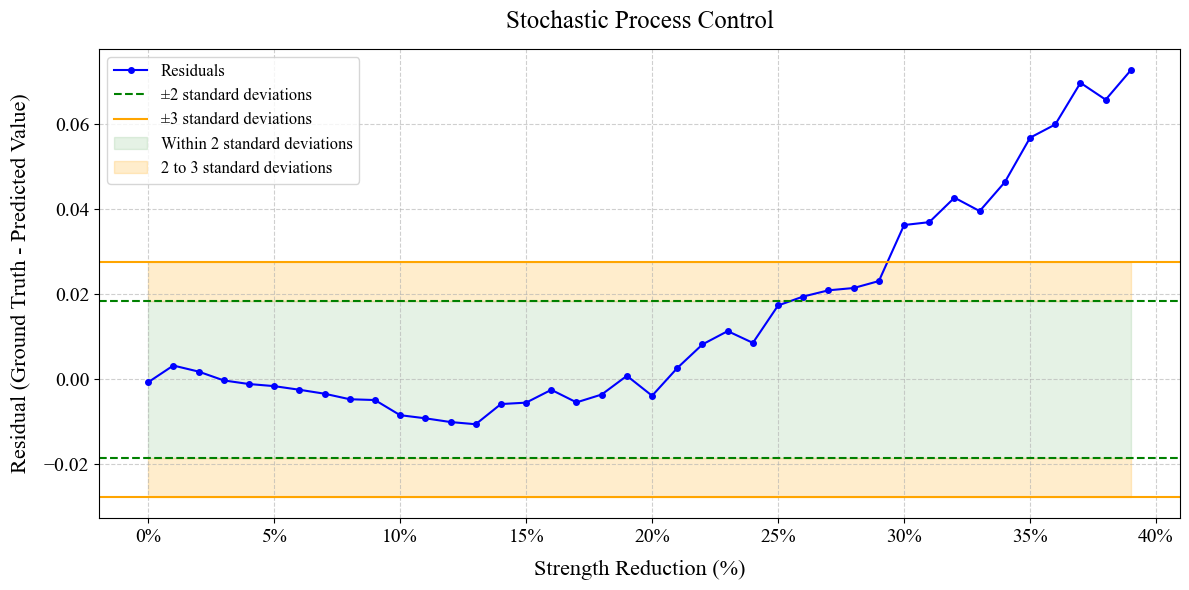

In [189]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Calculate the average of BB_Z_std
AVG_BB_Z_std = np.mean(BB_Z_std)
print(AVG_BB_Z_std)

# Predict values and calculate residuals
DETECT_Z_B_AVG_PRED, DETECT_Z_B_AVG_PRED_std = gprMdl_Z.predict(DETECT_Z_A_AVG.reshape(-1,1), return_std=True)
Residual_Z = DETECT_Z_B_AVG - DETECT_Z_B_AVG_PRED

# Plot the residual & control limits +- 2 std, +- 3 std
fig = plt.figure(figsize=(12, 6))
plt.plot(Residual_Z, color='blue', marker='o', linestyle='-', linewidth=1.5, markersize=4, label='Residuals')
plt.axhline(y=2*AVG_BB_Z_std, color='green', linestyle='--', linewidth=1.5)
plt.axhline(y=-2*AVG_BB_Z_std, color='green', linestyle='--', linewidth=1.5, label='±2 standard deviations')
plt.axhline(y=3*AVG_BB_Z_std, color='orange', linestyle='-', linewidth=1.5)
plt.axhline(y=-3*AVG_BB_Z_std, color='orange', linestyle='-', linewidth=1.5, label='±3 standard deviations')

# Shaded areas
plt.fill_between(range(len(Residual_Z)), -2*AVG_BB_Z_std, 2*AVG_BB_Z_std, color='green', alpha=0.1, label='Within 2 standard deviations')
plt.fill_between(range(len(Residual_Z)), 2*AVG_BB_Z_std, 3*AVG_BB_Z_std, color='orange', alpha=0.2, label='2 to 3 standard deviations')
plt.fill_between(range(len(Residual_Z)), -3*AVG_BB_Z_std, -2*AVG_BB_Z_std, color='orange', alpha=0.2)

# Formatter function to add percentage symbol
def percentage_formatter(x, pos):
    return f'{int(x)}%'

# Apply the formatter to the x-axis
ax = plt.gca()
ax.xaxis.set_major_formatter(FuncFormatter(percentage_formatter))

# Adjust tick label font size
plt.tick_params(axis='both', which='major', labelsize=14)

# Add labels, title, legend, and grid
plt.xlabel('Strength Reduction (%)', fontsize=16, labelpad=10)
plt.ylabel('Residual (Ground Truth - Predicted Value)', fontsize=16, labelpad=10)
plt.title('Stochastic Process Control', fontsize=18, pad=15)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()


0.009231262472978482


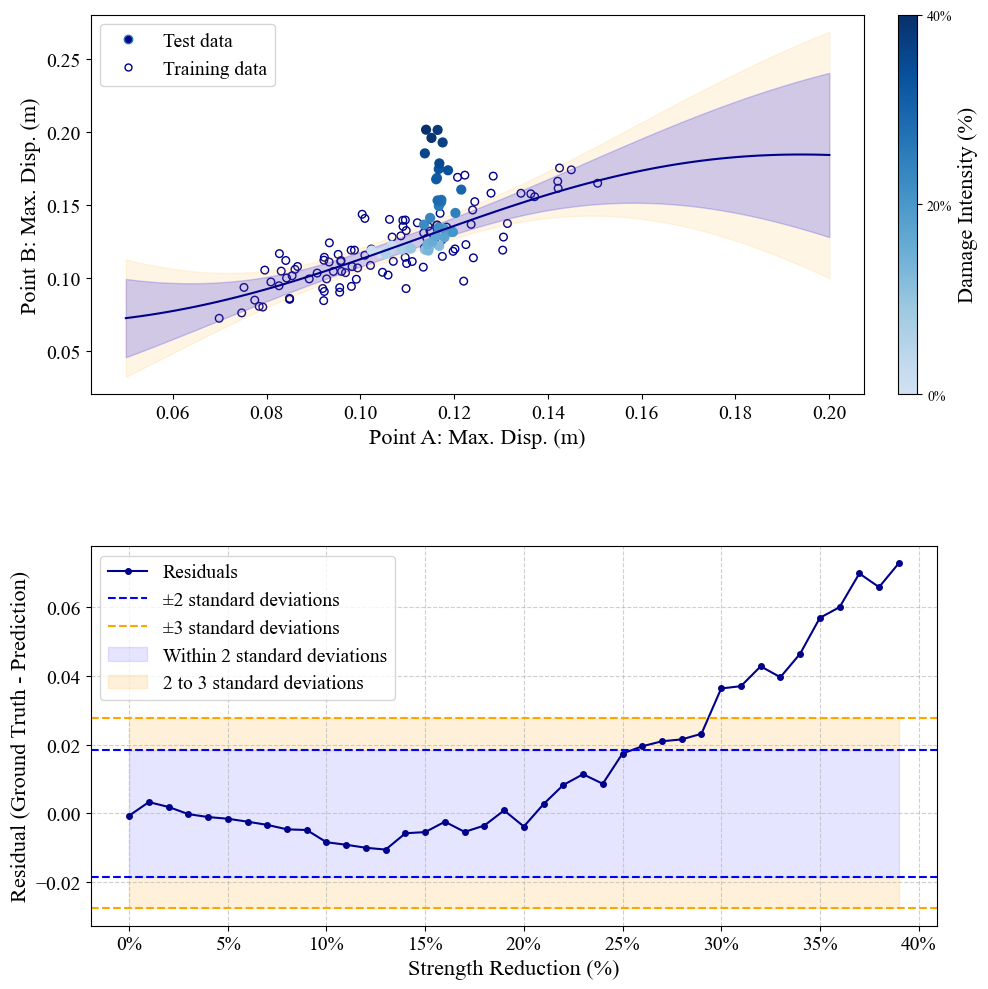

In [190]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FuncFormatter

# Define a custom blue colormap that starts from a light blue and goes to deep blue
light_to_dark_blue = LinearSegmentedColormap.from_list("light_to_dark_blue", cm.Blues(np.linspace(0.2, 1, 256)))

# Calculate the average of BB_Z_std for the second subplot
AVG_BB_Z_std = np.mean(BB_Z_std)
print(AVG_BB_Z_std)

# Predict values and calculate residuals
DETECT_Z_B_AVG_PRED, DETECT_Z_B_AVG_PRED_std = gprMdl_Z.predict(DETECT_Z_A_AVG.reshape(-1, 1), return_std=True)
Residual_Z = DETECT_Z_B_AVG - DETECT_Z_B_AVG_PRED

# Create the figure with two subplots in one column
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Common font sizes for consistency
label_font_size = 16
title_font_size = 18
tick_font_size = 14
legend_font_size = 14

# First subplot: Regression and test data with smaller circle sizes
ax1.scatter(BASE_Z_A, BASE_Z_B, edgecolors='darkblue', facecolors='none', label='Training data', marker='o', s=30)  # Smaller hollow circles for training data
ax1.plot(AA_Z, BB_Z, c='darkblue', label='Regression')
ax1.fill_between(AA_Z.squeeze(), (BB_Z - 2 * BB_Z_std).squeeze(), (BB_Z + 2 * BB_Z_std).squeeze(), color='blue', alpha=0.2)
ax1.fill_between(AA_Z.squeeze(), (BB_Z - 3 * BB_Z_std).squeeze(), (BB_Z + 3 * BB_Z_std).squeeze(), color='orange', alpha=0.1)

# Generate colors from light to dark based on damage intensity
damage_levels = np.linspace(0, 1, len(DETECT_Z_A_AVG))  # Normalized values from 0 to 1

# Plot test data with the custom blue gradient and smaller solid circle markers (no edge)
scatter = ax1.scatter(DETECT_Z_A_AVG, DETECT_Z_B_AVG, c=damage_levels, cmap=light_to_dark_blue, label='Test data', 
                      facecolors='darkblue', marker='o', s=40)

# Add colorbar inside the first subplot
cbar = plt.colorbar(scatter, ax=ax1, orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label('Damage Intensity (%)', fontsize=label_font_size)
cbar.set_ticks([0, 0.5, 1])  # Set ticks to show 0%, 20%, and 40%
cbar.set_ticklabels(['0%', '20%', '40%'])

# Set title and labels for the first subplot
# ax1.set_title('Regression Model of Z Direction Displacement', fontsize=title_font_size, pad=15, loc='center')
ax1.set_xlabel('Point A: Max. Disp. (m)', fontsize=label_font_size)
ax1.set_ylabel('Point B: Max. Disp. (m)', fontsize=label_font_size)
ax1.tick_params(axis='both', which='major', labelsize=tick_font_size)

# Use appropriate legend labels and markers
ax1.legend(handles=[plt.Line2D([], [], marker='o', markerfacecolor='darkblue', linestyle='None', label='Test data'),
                    plt.Line2D([], [], marker='o', markerfacecolor='none', markeredgecolor='darkblue', markersize=5, linestyle='None', label='Training data')],
           fontsize=legend_font_size)

# Second subplot: Residual and control limits
ax2.plot(Residual_Z, color='darkblue', marker='o', linestyle='-', linewidth=1.5, markersize=4, label='Residuals')
ax2.axhline(y=2 * AVG_BB_Z_std, color='blue', linestyle='--', linewidth=1.5)
ax2.axhline(y=-2 * AVG_BB_Z_std, color='blue', linestyle='--', linewidth=1.5, label='±2 standard deviations')
ax2.axhline(y=3 * AVG_BB_Z_std, color='orange', linestyle='--', linewidth=1.5)
ax2.axhline(y=-3 * AVG_BB_Z_std, color='orange', linestyle='--', linewidth=1.5, label='±3 standard deviations')

# Shaded areas for the second subplot
ax2.fill_between(range(len(Residual_Z)), -2 * AVG_BB_Z_std, 2 * AVG_BB_Z_std, color='blue', alpha=0.1, label='Within 2 standard deviations')
ax2.fill_between(range(len(Residual_Z)), 2 * AVG_BB_Z_std, 3 * AVG_BB_Z_std, color='orange', alpha=0.15, label='2 to 3 standard deviations')
ax2.fill_between(range(len(Residual_Z)), -3 * AVG_BB_Z_std, -2 * AVG_BB_Z_std, color='orange', alpha=0.15)

# Formatter function to add percentage symbol
def percentage_formatter(x, pos):
    return f'{int(x)}%'

# Apply the formatter to the x-axis of the second subplot
ax2.xaxis.set_major_formatter(FuncFormatter(percentage_formatter))

# Set title and labels for the second subplot
# ax2.set_title('Stochastic Process Control', fontsize=title_font_size, pad=15, loc='center')
ax2.set_xlabel('Strength Reduction (%)', fontsize=label_font_size)
ax2.set_ylabel('Residual (Ground Truth - Prediction)', fontsize=label_font_size)
ax2.tick_params(axis='both', which='major', labelsize=tick_font_size)

# Legend and grid for the second subplot
ax2.legend(fontsize=legend_font_size)
ax2.grid(True, linestyle='--', alpha=0.6)

# Adjust layout to ensure alignment and add padding between subplots
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)  # Increase space between subplots

# Save the picture
plt.savefig('analyze', dpi=300)

# Show the combined figure with two subplots
plt.show()
